# EDA: Class Distribution Analysis
Analyze class distribution patterns for OSAS detection dataset
- Plot binary and multiclass distribution
- Visualize window counts per class
- Detect skew between patients

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Dataset

In [ ]:
# Load the dataset
try:
    dataset = pd.read_pickle('./data/dataset_OSAS.pickle')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found...")

print(f"Dataset shape: {dataset.shape}")
print(f"Unique patients: {dataset['patient'].nunique()}")

Dataset loaded successfully!
Dataset shape: (961357, 18)
Unique patients: 30


## 1. Overall Class Distribution

In [3]:
# Binary classification distribution
binary_counts = dataset['anomaly'].value_counts()
binary_percentages = dataset['anomaly'].value_counts(normalize=True) * 100

print("BINARY CLASSIFICATION DISTRIBUTION:")
print("=" * 40)
for label, count in binary_counts.items():
    print(f"{'Anomaly' if label else 'Normal'}: {count:,} ({binary_percentages[label]:.1f}%)")

# Multiclass distribution
multiclass_counts = dataset['event'].value_counts()
multiclass_percentages = dataset['event'].value_counts(normalize=True) * 100

print("\nMULTICLASS DISTRIBUTION:")
print("=" * 40)
for event, count in multiclass_counts.items():
    print(f"{event}: {count:,} ({multiclass_percentages[event]:.1f}%)")

BINARY CLASSIFICATION DISTRIBUTION:
Normal: 815,917 (84.9%)
Anomaly: 145,440 (15.1%)

MULTICLASS DISTRIBUTION:
NONE: 815,917 (84.9%)
HYPOPNEA: 78,035 (8.1%)
APNEA-OBSTRUCTIVE: 44,217 (4.6%)
APNEA-MIXED: 12,360 (1.3%)
APNEA-CENTRAL: 10,828 (1.1%)


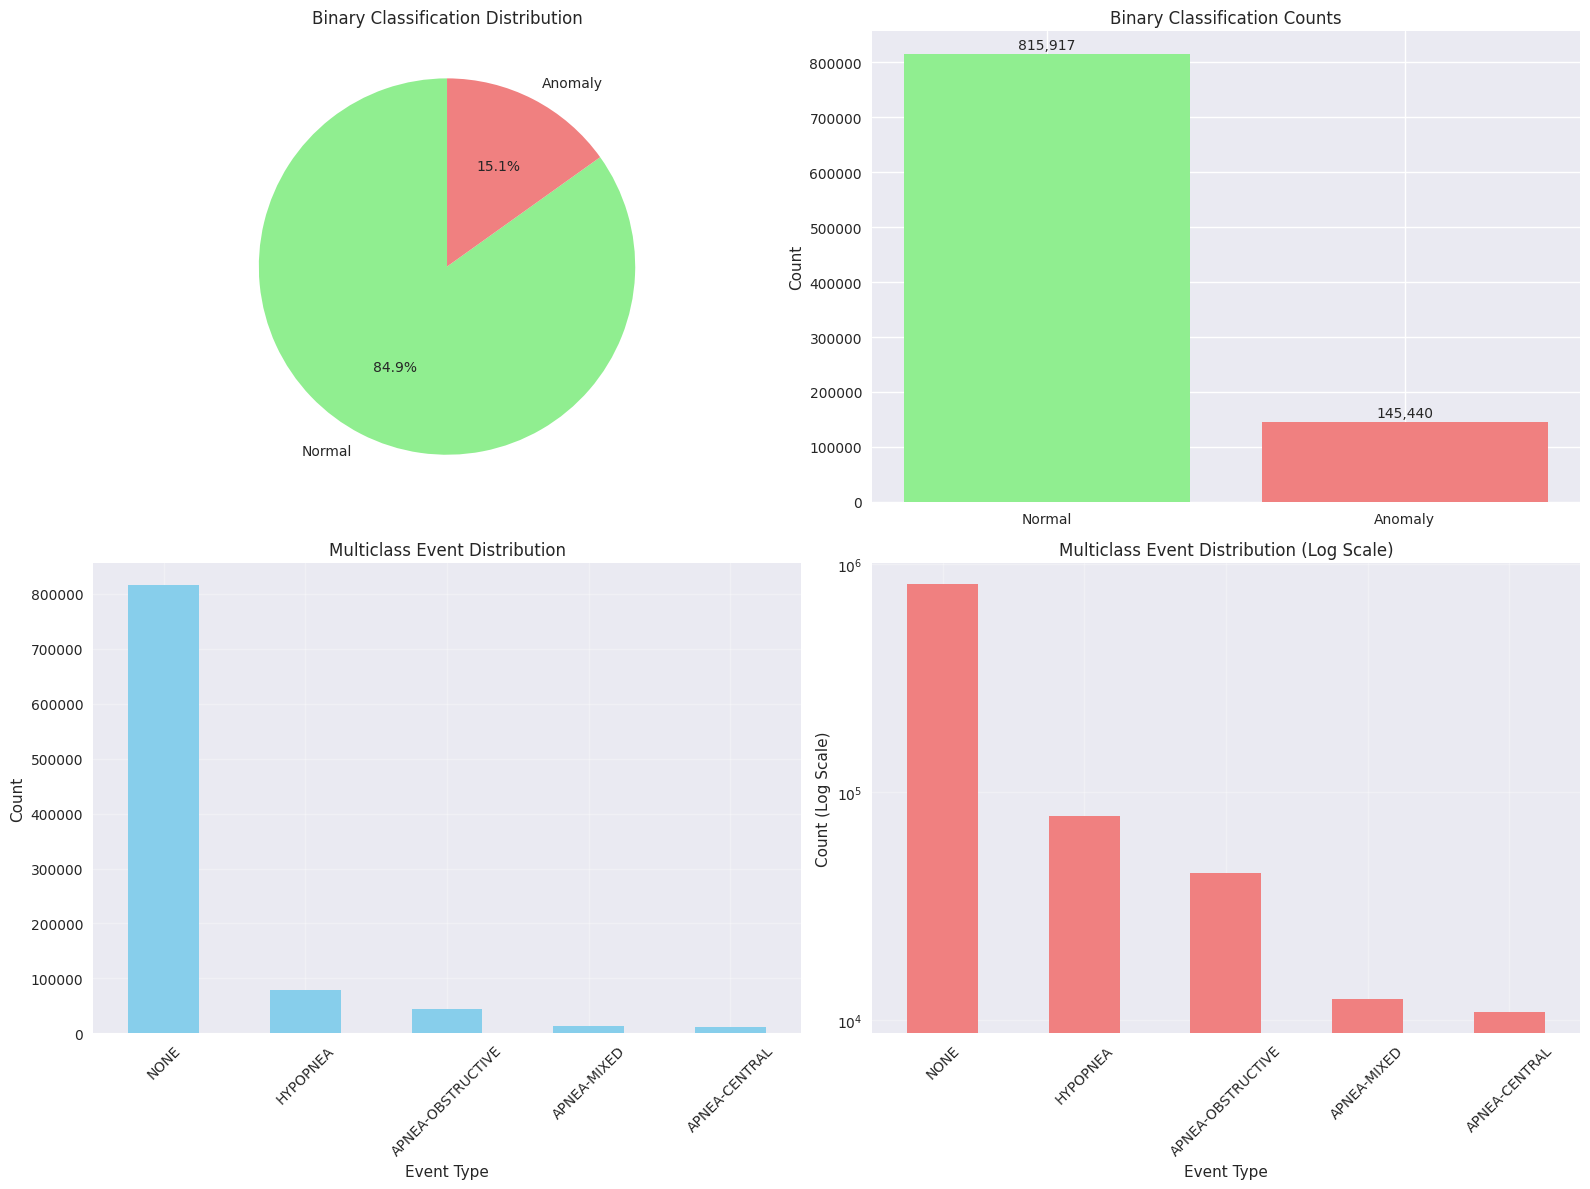

In [4]:
# Visualize class distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Binary distribution - pie chart
labels = ['Normal', 'Anomaly']
sizes = [binary_counts[False], binary_counts[True]]
colors = ['lightgreen', 'lightcoral']
axes[0,0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Binary Classification Distribution')

# Binary distribution - bar chart
axes[0,1].bar(labels, sizes, color=colors)
axes[0,1].set_title('Binary Classification Counts')
axes[0,1].set_ylabel('Count')
for i, v in enumerate(sizes):
    axes[0,1].text(i, v + max(sizes)*0.01, f'{v:,}', ha='center')

# Multiclass distribution - bar chart
multiclass_counts.plot(kind='bar', ax=axes[1,0], color='skyblue')
axes[1,0].set_title('Multiclass Event Distribution')
axes[1,0].set_xlabel('Event Type')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Multiclass distribution - log scale
multiclass_counts.plot(kind='bar', ax=axes[1,1], color='lightcoral', logy=True)
axes[1,1].set_title('Multiclass Event Distribution (Log Scale)')
axes[1,1].set_xlabel('Event Type')
axes[1,1].set_ylabel('Count (Log Scale)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Class Imbalance Analysis

In [5]:
# Calculate imbalance ratios
def calculate_imbalance_ratio(counts):
    """Calculate imbalance ratio (majority class / minority class)"""
    return counts.max() / counts.min()

binary_imbalance = calculate_imbalance_ratio(binary_counts)
multiclass_imbalance = calculate_imbalance_ratio(multiclass_counts)

print("CLASS IMBALANCE ANALYSIS:")
print("=" * 40)
print(f"Binary Classification Imbalance Ratio: {binary_imbalance:.1f}:1")
print(f"Multiclass Classification Imbalance Ratio: {multiclass_imbalance:.1f}:1")
print(f"Most frequent class: {multiclass_counts.index[0]} ({multiclass_percentages.iloc[0]:.1f}%)")
print(f"Least frequent class: {multiclass_counts.index[-1]} ({multiclass_percentages.iloc[-1]:.2f}%)")

CLASS IMBALANCE ANALYSIS:
Binary Classification Imbalance Ratio: 5.6:1
Multiclass Classification Imbalance Ratio: 75.4:1
Most frequent class: NONE (84.9%)
Least frequent class: APNEA-CENTRAL (1.13%)


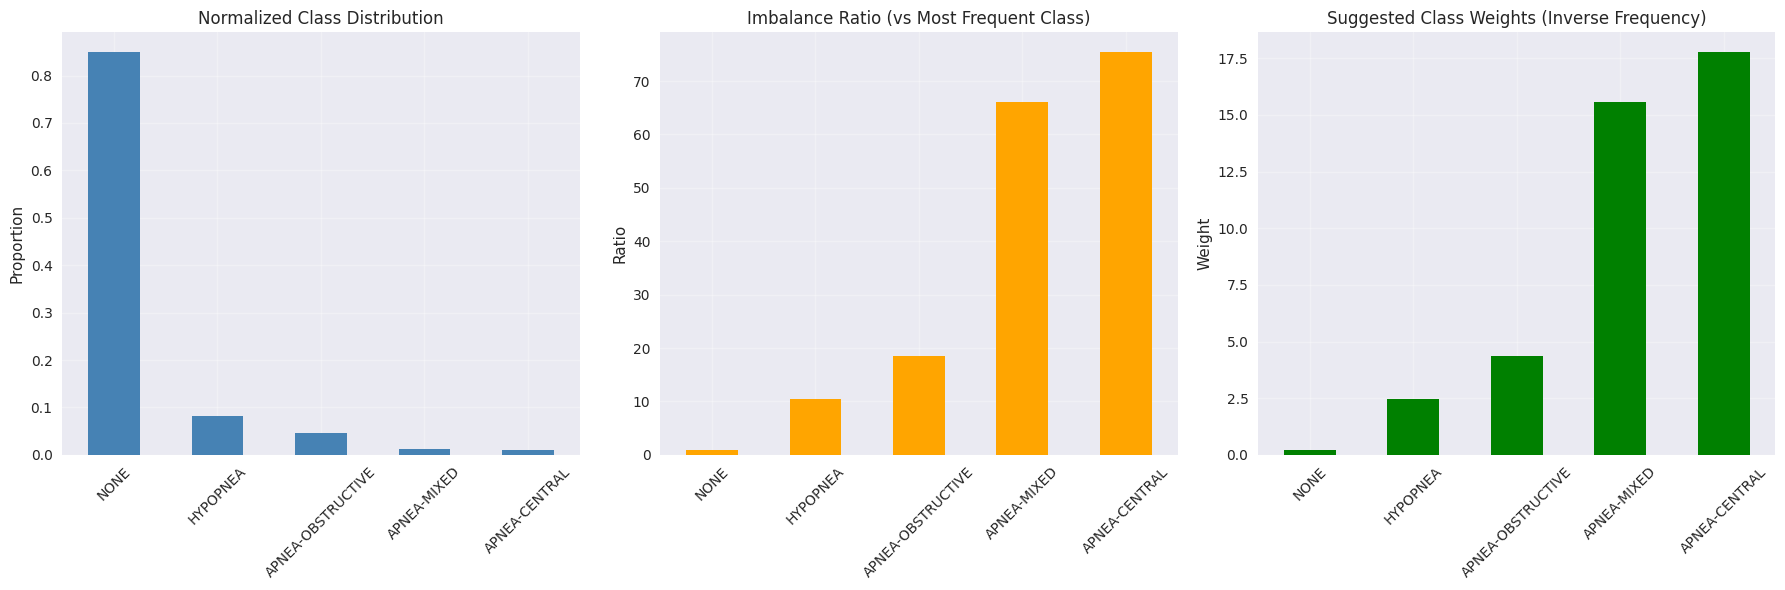


SUGGESTED CLASS WEIGHTS:
NONE: 0.24
HYPOPNEA: 2.46
APNEA-OBSTRUCTIVE: 4.35
APNEA-MIXED: 15.56
APNEA-CENTRAL: 17.76


In [6]:
# Visualize imbalance with different perspectives
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Normalized bar chart
normalized_counts = multiclass_counts / multiclass_counts.sum()
normalized_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Normalized Class Distribution')
axes[0].set_ylabel('Proportion')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Imbalance ratio for each class vs most frequent
imbalance_ratios = multiclass_counts.max() / multiclass_counts
imbalance_ratios.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Imbalance Ratio (vs Most Frequent Class)')
axes[1].set_ylabel('Ratio')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Class weights (inverse frequency)
total_samples = len(dataset)
n_classes = len(multiclass_counts)
class_weights = total_samples / (n_classes * multiclass_counts)
class_weights.plot(kind='bar', ax=axes[2], color='green')
axes[2].set_title('Suggested Class Weights (Inverse Frequency)')
axes[2].set_ylabel('Weight')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSUGGESTED CLASS WEIGHTS:")
for event, weight in class_weights.items():
    print(f"{event}: {weight:.2f}")

## 3. Patient-wise Class Distribution

In [7]:
# Class distribution per patient
patient_event_counts = dataset.groupby(['patient', 'event']).size().unstack(fill_value=0)
patient_anomaly_counts = dataset.groupby(['patient', 'anomaly']).size().unstack(fill_value=0)

# Calculate anomaly rates per patient
patient_anomaly_rates = patient_anomaly_counts[True] / (patient_anomaly_counts[True] + patient_anomaly_counts[False]) * 100

print("Patient-wise anomaly rates (%):\n")
print(patient_anomaly_rates.describe())

print(f"\nPatients with highest anomaly rates:")
print(patient_anomaly_rates.nlargest(5))

print(f"\nPatients with lowest anomaly rates:")
print(patient_anomaly_rates.nsmallest(5))

Patient-wise anomaly rates (%):

count    30.000000
mean     15.544654
std      13.120230
min       0.161357
25%       3.963007
50%      12.470180
75%      23.494364
max      41.332451
dtype: float64

Patients with highest anomaly rates:
patient
3     41.332451
26    37.258050
30    36.099670
16    34.249073
15    33.327292
dtype: float64

Patients with lowest anomaly rates:
patient
23    0.161357
8     0.635861
22    1.132910
18    1.683624
29    1.990191
dtype: float64


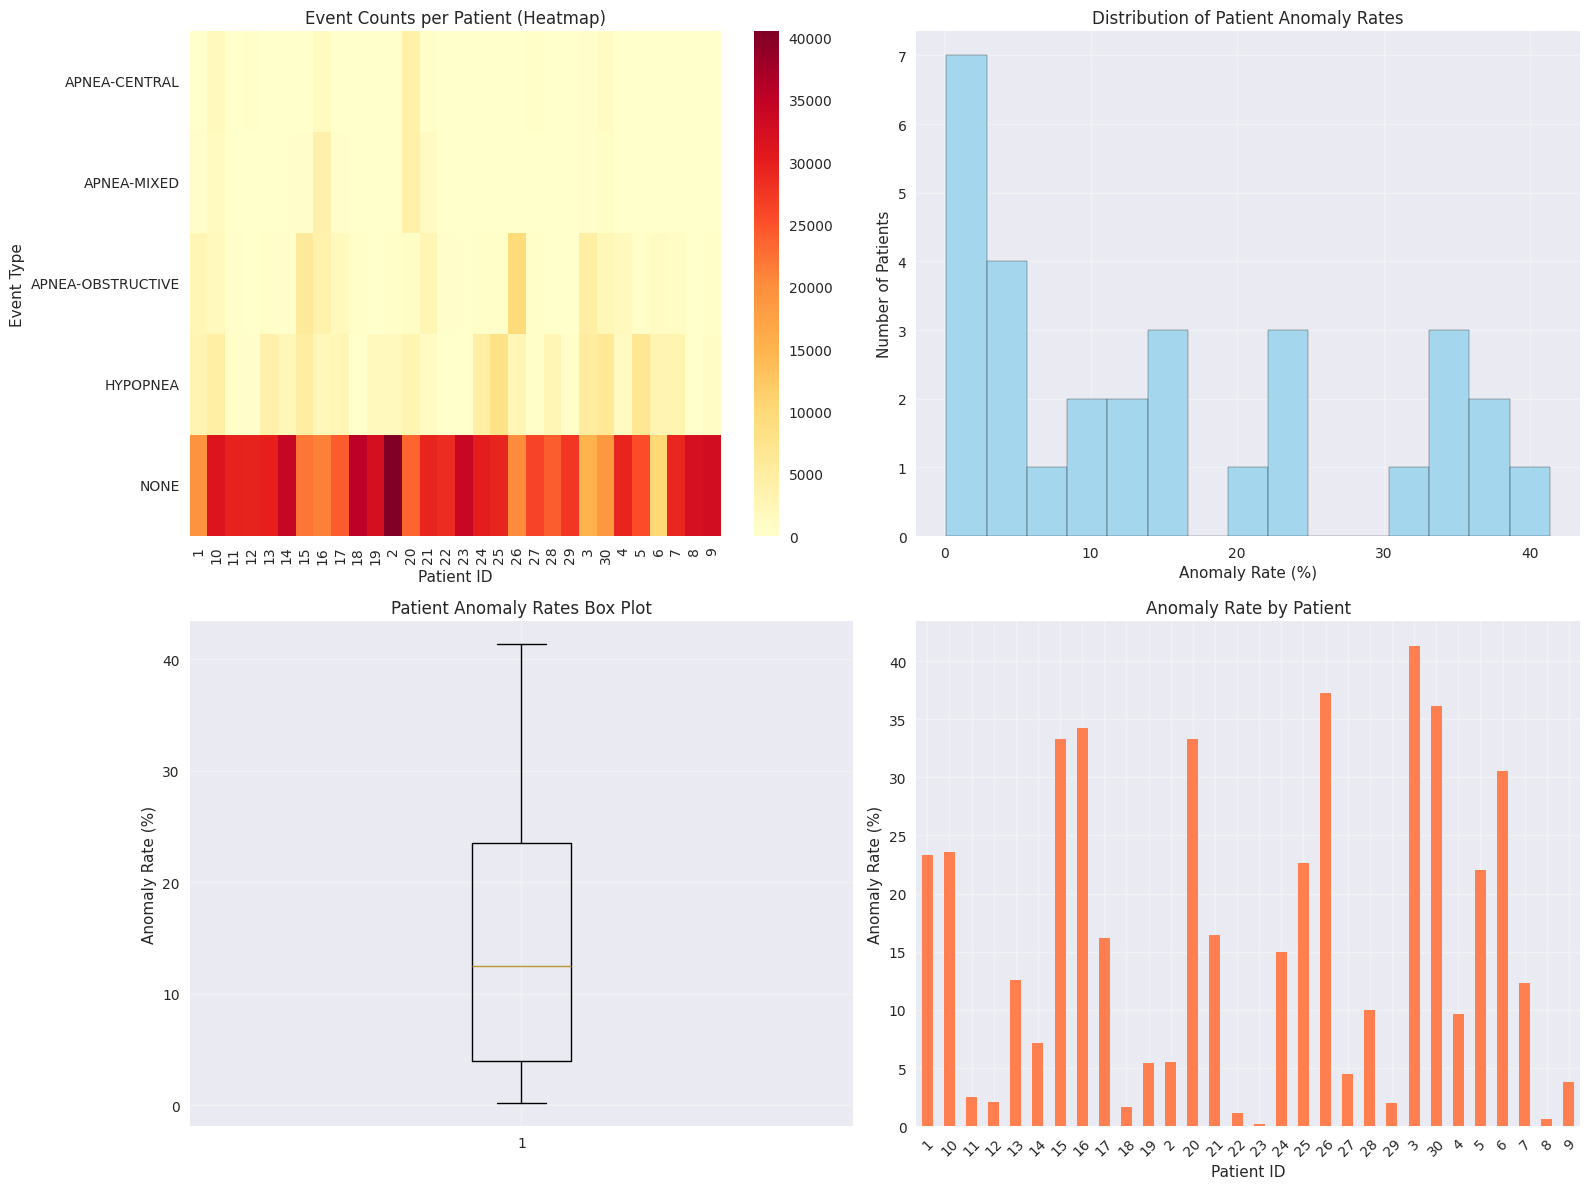

In [8]:
# Visualize patient-wise distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap of event counts per patient
sns.heatmap(patient_event_counts.T, cmap='YlOrRd', annot=False, ax=axes[0,0])
axes[0,0].set_title('Event Counts per Patient (Heatmap)')
axes[0,0].set_xlabel('Patient ID')
axes[0,0].set_ylabel('Event Type')

# Distribution of patient anomaly rates
axes[0,1].hist(patient_anomaly_rates.values, bins=15, alpha=0.7, edgecolor='black', color='skyblue')
axes[0,1].set_title('Distribution of Patient Anomaly Rates')
axes[0,1].set_xlabel('Anomaly Rate (%)')
axes[0,1].set_ylabel('Number of Patients')
axes[0,1].grid(True, alpha=0.3)

# Box plot of anomaly rates
axes[1,0].boxplot(patient_anomaly_rates.values)
axes[1,0].set_title('Patient Anomaly Rates Box Plot')
axes[1,0].set_ylabel('Anomaly Rate (%)')
axes[1,0].grid(True, alpha=0.3)

# Bar plot of anomaly rates per patient
patient_anomaly_rates.plot(kind='bar', ax=axes[1,1], color='coral')
axes[1,1].set_title('Anomaly Rate by Patient')
axes[1,1].set_xlabel('Patient ID')
axes[1,1].set_ylabel('Anomaly Rate (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Class Skew Analysis

In [9]:
# Detect patients with extreme class distributions
from scipy import stats

# Calculate statistics for patient anomaly rates
mean_rate = patient_anomaly_rates.mean()
std_rate = patient_anomaly_rates.std()
median_rate = patient_anomaly_rates.median()

# Identify outlier patients (using IQR method)
Q1 = patient_anomaly_rates.quantile(0.25)
Q3 = patient_anomaly_rates.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_patients = patient_anomaly_rates[(patient_anomaly_rates < lower_bound) | 
                                        (patient_anomaly_rates > upper_bound)]

print("CLASS SKEW ANALYSIS:")
print("=" * 40)
print(f"Mean anomaly rate across patients: {mean_rate:.1f}%")
print(f"Median anomaly rate: {median_rate:.1f}%")
print(f"Standard deviation: {std_rate:.1f}%")
print(f"Range: {patient_anomaly_rates.min():.1f}% - {patient_anomaly_rates.max():.1f}%")
print(f"\nOutlier patients ({len(outlier_patients)} found):")
for patient_id, rate in outlier_patients.items():
    print(f"  Patient {patient_id}: {rate:.1f}% anomaly rate")

CLASS SKEW ANALYSIS:
Mean anomaly rate across patients: 15.5%
Median anomaly rate: 12.5%
Standard deviation: 13.1%
Range: 0.2% - 41.3%

Outlier patients (0 found):


In [10]:
# Analyze event type distribution across patients
patient_event_proportions = patient_event_counts.div(patient_event_counts.sum(axis=1), axis=0)

print("\nEvent type proportions per patient (mean ± std):")
print("=" * 50)
for event in patient_event_proportions.columns:
    mean_prop = patient_event_proportions[event].mean() * 100
    std_prop = patient_event_proportions[event].std() * 100
    print(f"{event}: {mean_prop:.1f}% ± {std_prop:.1f}%")


Event type proportions per patient (mean ± std):
APNEA-CENTRAL: 1.1% ± 2.3%
APNEA-MIXED: 1.2% ± 3.0%
APNEA-OBSTRUCTIVE: 4.8% ± 6.8%
HYPOPNEA: 8.4% ± 7.0%
NONE: 84.5% ± 13.1%


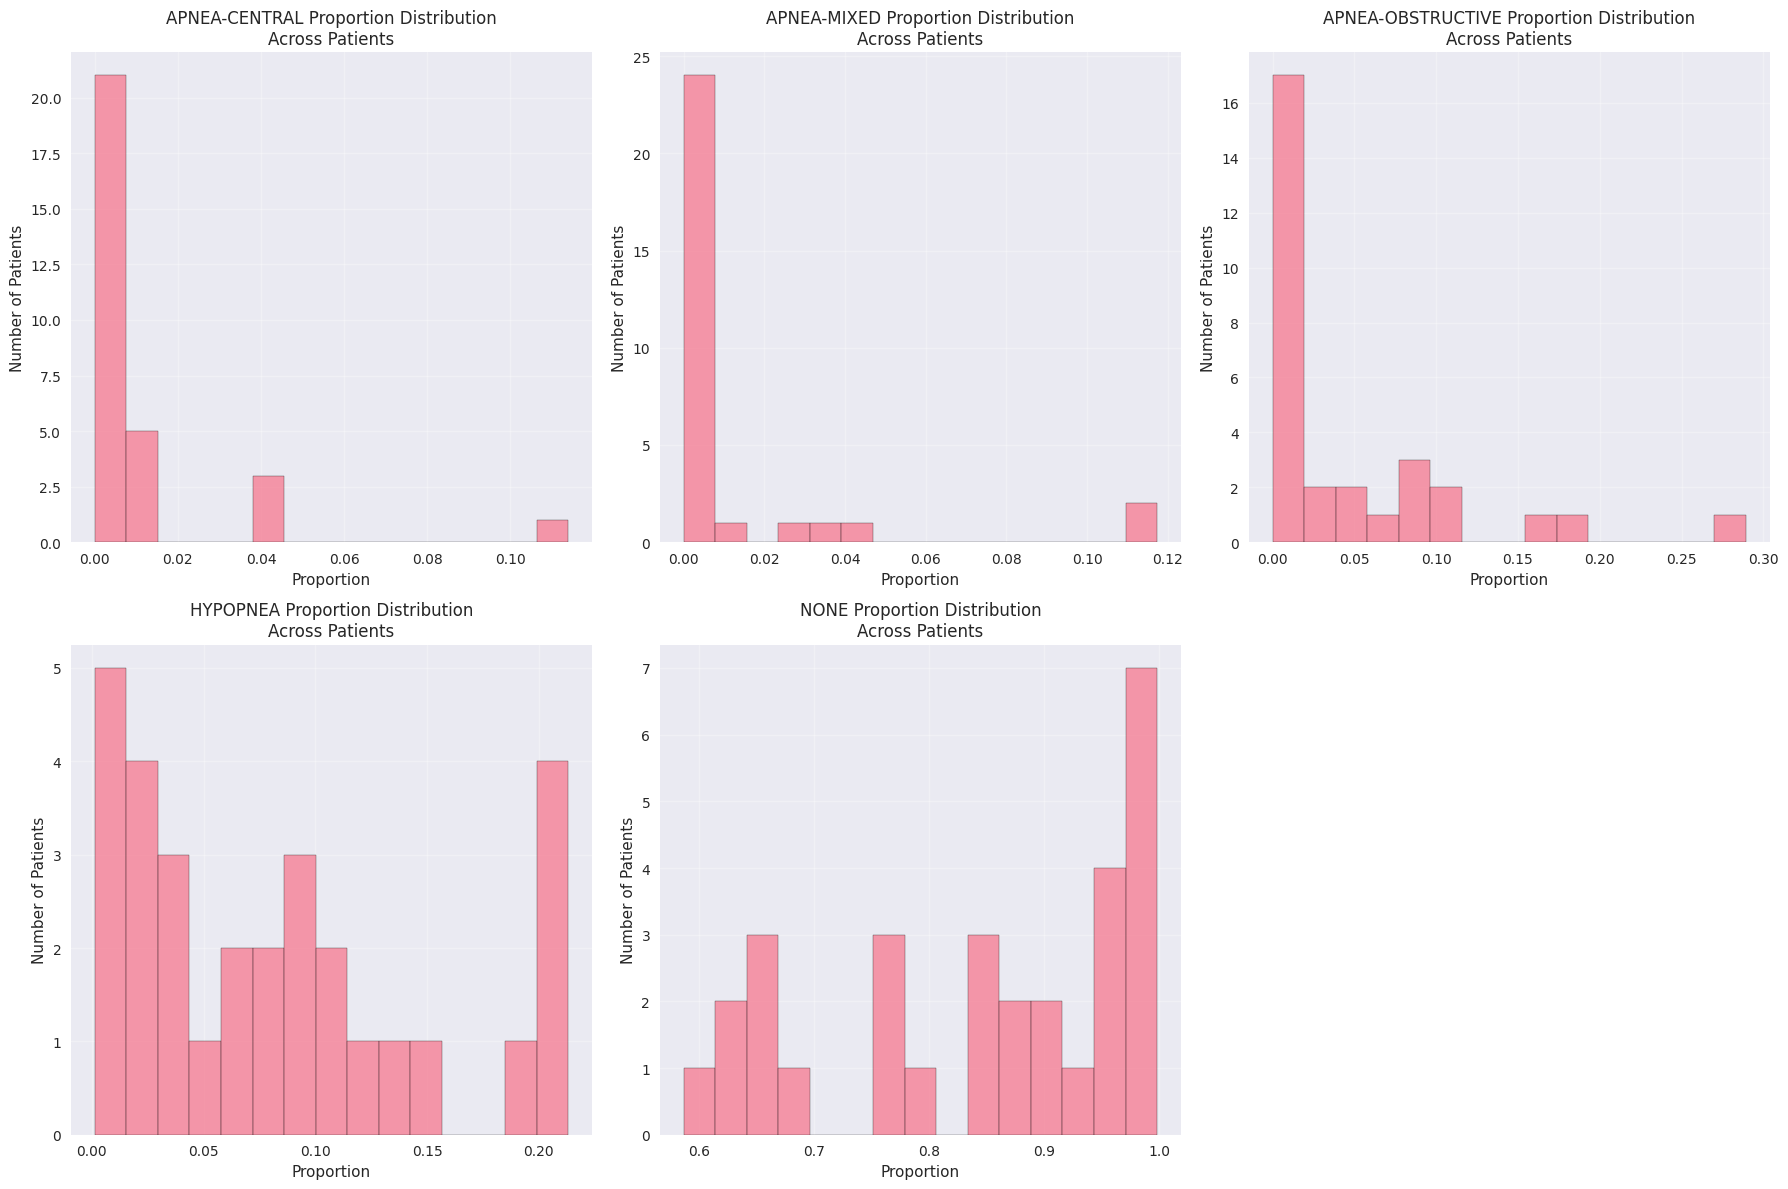

In [11]:
# Visualize event proportions across patients
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

events = patient_event_proportions.columns
for i, event in enumerate(events):
    if i < len(axes):
        patient_event_proportions[event].hist(bins=15, alpha=0.7, ax=axes[i], edgecolor='black')
        axes[i].set_title(f'{event} Proportion Distribution\nAcross Patients')
        axes[i].set_xlabel('Proportion')
        axes[i].set_ylabel('Number of Patients')
        axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(events), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## 5. Recommendations for Handling Imbalance

In [12]:
# Calculate recommended strategies
print("RECOMMENDATIONS FOR HANDLING CLASS IMBALANCE:")
print("=" * 50)

print("\n1. CLASS WEIGHTS (for loss function):")
print("   Binary classification:")
binary_weights = len(dataset) / (2 * binary_counts)
print(f"     Normal: {binary_weights[False]:.2f}")
print(f"     Anomaly: {binary_weights[True]:.2f}")

print("\n   Multiclass classification:")
for event, weight in class_weights.items():
    print(f"     {event}: {weight:.2f}")

print("\n2. SAMPLING STRATEGIES:")
print(f"   Current minority class size: {multiclass_counts.min():,}")
print(f"   Suggested upsampling target: {multiclass_counts.max():,} (match majority)")
print(f"   Alternative balanced target: {int(multiclass_counts.mean()):,} (average size)")

print("\n3. EVALUATION METRICS:")
print("   Recommended metrics for imbalanced data:")
print("   - Macro-averaged F1 score")
print("   - Per-class Precision, Recall, F1")
print("   - Area Under ROC Curve (AUC-ROC)")
print("   - Area Under Precision-Recall Curve (AUC-PR)")
print("   - Confusion Matrix")

print("\n4. STRATIFICATION STRATEGY:")
print("   Use stratified sampling for train/val/test splits")
print("   Consider patient-level stratification to avoid data leakage")
print(f"   Minimum samples per fold for rarest class: {multiclass_counts.min()}")

RECOMMENDATIONS FOR HANDLING CLASS IMBALANCE:

1. CLASS WEIGHTS (for loss function):
   Binary classification:
     Normal: 0.59
     Anomaly: 3.30

   Multiclass classification:
     NONE: 0.24
     HYPOPNEA: 2.46
     APNEA-OBSTRUCTIVE: 4.35
     APNEA-MIXED: 15.56
     APNEA-CENTRAL: 17.76

2. SAMPLING STRATEGIES:
   Current minority class size: 10,828
   Suggested upsampling target: 815,917 (match majority)
   Alternative balanced target: 192,271 (average size)

3. EVALUATION METRICS:
   Recommended metrics for imbalanced data:
   - Macro-averaged F1 score
   - Per-class Precision, Recall, F1
   - Area Under ROC Curve (AUC-ROC)
   - Area Under Precision-Recall Curve (AUC-PR)
   - Confusion Matrix

4. STRATIFICATION STRATEGY:
   Use stratified sampling for train/val/test splits
   Consider patient-level stratification to avoid data leakage
   Minimum samples per fold for rarest class: 10828


## 6. Patient-level Analysis for Model Validation

In [13]:
# Analyze patient-level characteristics for proper train/test splitting
patient_stats = dataset.groupby('patient').agg({
    'anomaly': ['count', 'sum', 'mean'],
    'event': lambda x: x.value_counts().to_dict()
}).round(3)

patient_stats.columns = ['total_records', 'anomaly_count', 'anomaly_rate', 'event_distribution']

print("PATIENT-LEVEL STATISTICS FOR MODEL VALIDATION:")
print("=" * 55)
print(patient_stats.head(10))

# Check if any patients have only one class
single_class_patients = patient_stats[patient_stats['anomaly_rate'].isin([0.0, 1.0])]
if len(single_class_patients) > 0:
    print(f"\n⚠️  WARNING: {len(single_class_patients)} patients have only one class:")
    print(single_class_patients[['anomaly_rate']])
    print("   Consider this when splitting data to avoid issues.")
else:
    print("\n✅ All patients have both normal and anomaly samples.")

PATIENT-LEVEL STATISTICS FOR MODEL VALIDATION:
         total_records  anomaly_count  anomaly_rate  \
patient                                               
1                25178           5870         0.233   
10               41058           9671         0.236   
11               30400            752         0.025   
12               30146            633         0.021   
13               34036           4284         0.126   
14               36920           2633         0.071   
15               33105          11033         0.333   
16               32360          11083         0.342   
17               28987           4684         0.162   
18               35875            604         0.017   

                                        event_distribution  
patient                                                     
1        {'NONE': 19308, 'HYPOPNEA': 3057, 'APNEA-OBSTR...  
10       {'NONE': 31387, 'HYPOPNEA': 4601, 'APNEA-CENTR...  
11       {'NONE': 29648, 'HYPOPNEA': 518, 'APNEA

## Summary and Conclusions

### Key Findings:

1. **Severe Class Imbalance**: The dataset shows significant imbalance, especially in multiclass mode
2. **Patient Variability**: Anomaly rates vary significantly across patients
3. **Rare Events**: Some event types (APNEA-CENTRAL, APNEA-MIXED) are extremely rare

### Recommended Strategies:

1. **Use class weights** in loss function to penalize misclassification of minority classes
2. **Apply stratified sampling** for train/validation/test splits
3. **Consider patient-level splitting** to prevent data leakage
4. **Use appropriate evaluation metrics** (macro-F1, AUC-PR) for imbalanced data
5. **Consider oversampling techniques** (SMOTE, ADASYN) for training data
6. **Apply focal loss** to focus learning on hard examples

### Next Steps:
- Proceed to signal quality analysis
- Investigate label alignment patterns
- Design appropriate cross-validation strategy